In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
from tensorflow.keras.utils  import to_categorical, Sequence
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# %reload_ext autoreload
from models import UNet
from metrics import mIoU, dice, dice_coef
from loss import categorical_focal_loss
from utils import PlotHistoryNew

### Load Data

In [3]:
xtr = np.load('data/X_train.npy')
ytr = np.load('data/Y_train.npy')

xte = np.load('data/X_val.npy')
yte = np.load('data/Y_val.npy')

In [4]:
xtr.shape, ytr.shape, xte.shape, yte.shape

((34, 256, 256), (34, 256, 256), (5, 256, 256), (5, 256, 256))

In [5]:
xtr.max(), xte.max()

(1.0, 0.9004037685060565)

### Data Augmentation

In [6]:
# split
xtr, xvl, ytr, yvl = train_test_split(xtr, ytr,test_size=0.2, random_state=0)
xtr.shape, ytr.shape, xvl.shape, yvl.shape

((27, 256, 256), (27, 256, 256), (7, 256, 256), (7, 256, 256))

In [7]:
h,w,bs = 256,256,8

In [8]:
AUGMENTATIONS_TRAIN = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness(),
         ], p=0.3),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    A.RandomSizedCrop(min_max_height=(184, 256), height=h, width=w,p=0.5)
],p=1)


In [9]:
class CustomGenerator(Sequence):
    
    def __init__(self, x_set, y_set, batch_size, get_aug=False, augmentations=None):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.get_aug = get_aug
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        if self.get_aug:
            
            augmented =  [ self.augment(image=x, mask=y) for x, y in zip(batch_x, batch_y) ]
            batch_x = np.stack([np.expand_dims(x["image"], axis=-1) for x in augmented], axis=0)
            batch_y = np.stack([to_categorical(x["mask"], 2) for x in augmented], axis=0)

        else:
            batch_x = np.stack([np.expand_dims(x, axis=-1) for x in batch_x], axis=0)
            batch_y = np.stack([to_categorical(x, 2) for x in batch_y], axis=0)

        return batch_x.astype('float32'), batch_y.astype('float32')

    # def on_epoch_end(self):
    #     'Updates indexes after each epoch'
    #     print("Finish epoch")

In [10]:
train_gen = CustomGenerator(xtr, ytr, bs, get_aug=True, augmentations = AUGMENTATIONS_TRAIN)

In [11]:
for ii in train_gen:
    print(ii[0].shape, ii[1].shape)
    break

(8, 256, 256, 1) (8, 256, 256, 2)


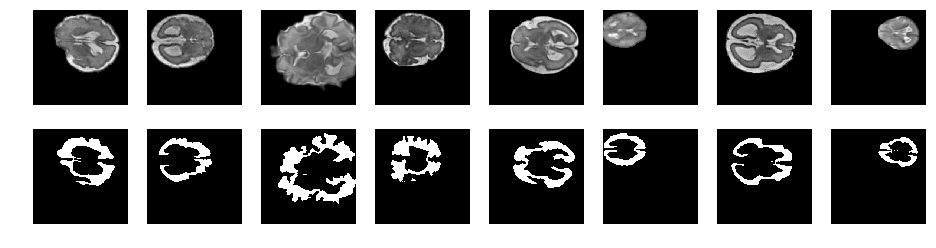

In [12]:
fig, axarr = plt.subplots(nrows=2, ncols=8, figsize=(16,4))

for i in range(8):
    axarr[0, i].imshow(ii[0][i][:,:,0], cmap = 'gray')
    axarr[1, i].imshow(ii[1][i][:,:,1], cmap = 'gray')
    axarr[0, i].axis('off')
    axarr[1, i].axis('off')

In [13]:
val_gen = CustomGenerator(xvl, yvl, batch_size=7)

### Modeling

In [14]:
model = UNet((h,w,1), n_classes=2, f1=32, BN=True)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
opt = Adam(lr = 0.0005)
lossf = categorical_focal_loss(gamma=2,alpha=1)

model.compile(optimizer = opt,
              loss = lossf, 
              metrics=['accuracy', dice])

### Training

In [16]:
patience = 50

filepath = 'res/brain_growth_unet_focal_aug1.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, period=1, monitor='val_dice', mode='max')
earlystopper = EarlyStopping(patience=patience,verbose=1, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=patience//2, min_lr=0.00001, monitor='val_loss', mode='min') # 'val_accuracy

cb = [earlystopper, checkpoint, reduce_lr]

In [17]:
_epochs = 2

hs = model.fit(train_gen,epochs=_epochs,
               steps_per_epoch=4,
               callbacks=cb,
               validation_data=val_gen, validation_steps=1,
               verbose = 1, workers = 0)

Train for 4 steps, validate for 1 steps
Epoch 1/2
3/4 [=====================>........] - ETA: 18s - loss: 0.0810 - accuracy: 0.8323 - dice: 0.3216
Epoch 00001: val_dice improved from -inf to 0.22678, saving model to res/brain_growth_unet_focal_aug1.hdf5
4/4 [==============================] - 88s 22s/step - loss: 0.0697 - accuracy: 0.8522 - dice: 0.3797 - val_loss: 0.6405 - val_accuracy: 0.3613 - val_dice: 0.2268
Epoch 2/2
3/4 [=====================>........] - ETA: 19s - loss: 0.0408 - accuracy: 0.8756 - dice: 0.5772
Epoch 00002: val_dice did not improve from 0.22678
4/4 [==============================] - 89s 22s/step - loss: 0.0378 - accuracy: 0.8840 - dice: 0.5913 - val_loss: 3.1730 - val_accuracy: 0.2378 - val_dice: 0.1994


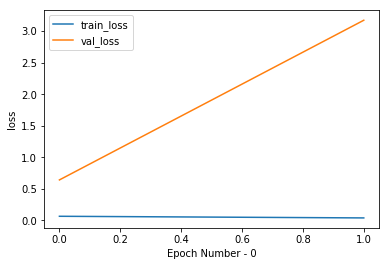

In [18]:
PlotHistoryNew(hs, "loss")

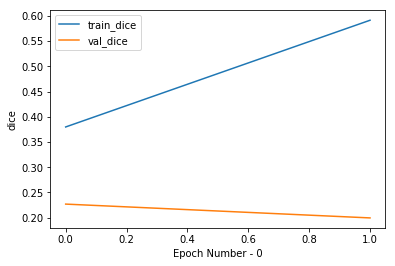

In [19]:
PlotHistoryNew(hs, "dice")

### Testing

In [20]:
filepath = 'res/weights_pretrained.hdf5'
model.load_weights(filepath)

In [21]:
xte = np.expand_dims(xte, axis=-1)

In [22]:
result = model.predict(xte)
yte_pred = np.argmax(result, axis=-1)

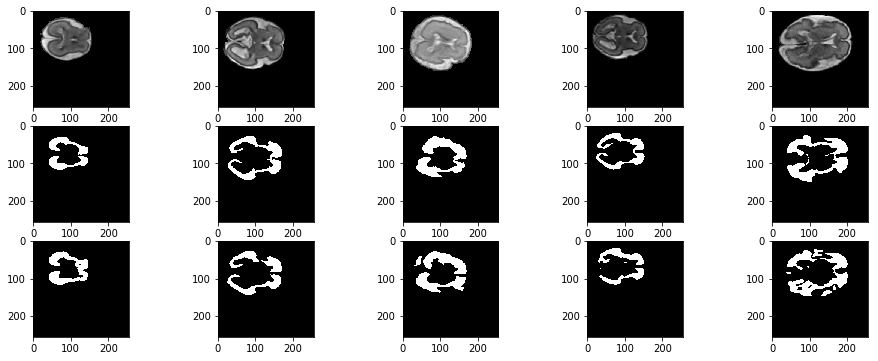

In [23]:
fig, axarr = plt.subplots(nrows=3, ncols=5, figsize=(16,6))

for i in range(5):
    axarr[0, i].imshow(xte[i][:,:,0], cmap = 'gray')
    axarr[1, i].imshow(yte[i], cmap = 'gray')
    axarr[2, i].imshow(yte_pred[i], cmap = 'gray')

In [24]:
mIoU(to_categorical(yte, 2), result).numpy()

0.8673035697012305

In [25]:
dice_coef(yte, yte_pred)

0.8668427200607084